#Descomposición manual de una serie temporal en R

Una **serie temporal** es una secuencia de observaciones ordenadas en el tiempo.

El análisis de series temporales incluye un conjunto muy amplio de técnicas, métodos, conceptos y estrategias con dos objetivos principales:
1. Describir las características de la serie temporal.
2. Predecir valores futuros.

En el presente cuaderno vamos a explicar cómo descomponer una serie temporal manualmente en R, y así poder describir sus principales características.

Una serie temporal cuenta con cuatro componentes principales:

* **Tendencia** (T): evolución de la serie a largo plazo. Un concepto intímamente relacionado con la tendencia, es el de **nivel**: el nivel de la serie viene dado por el valor de una medida de tendencia central, como la media o la mediana, en cada periodo de tiempo considerado. Por ejemplo, podemos observar el nivel de la serie a partir de la media anual. A su vez, observando la evolución en el tiempo del nivel, podemos ver si la serie presenta tendencia ascedente, descendente o no presenta tendencia (su nivel es estable o solamente sufre cambios circunstanciales).
* **Ciclo** (C): fluctuaciones de carácter periódico, pero no necesariamente regular, a medio plazo (más de un año) en torno a la tendencia. En numerosas ocasiones, se requiere de una serie muy larga para poder distinguir entre tendencia y ciclo, por lo que muchas veces resulta muy útil englobarlos en una sola componente llamada **ciclo-tendencia**. 
* **Estacionalidad** (S): variaciones regulares que se dan en el corto plazo. El corto plazo suele ser un año, aunque algunas series tienen estacionalidad mensual, semanal o, incluso, diaria. Estas fluctuaciones repetitivas suelen estar producidas por cuestiones climatológicas, de calendario, etc.
* **Componente aleatoria** o **residuo** (R): fluctuaciones aleatorias de la serie. Dentro de esta componente se encuentran los datos atípicos o *outliers*. La componente aleatoria se conoce como **ruido blanco** cuando su media es cero, su varianza es constante y los errores no están correlacionados.







###**Librerías**

In [ ]:
#Librería muy utilizada para el manejo de dataframes (en este caso, por ejemplo, nos permitirá renombrar columnas)
library(dplyr)
#Librería para la realización de medias móviles:
install.packages("forecast")
library(forecast)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



###**Datos**


Para ejemplificar cómo descomponer una serie temporal en R, vamos a emplear el IPC del pescado y del marisco entre enero de 2002 y diciembre de 2021.

Los datos los podemos obtener en el siguiente enlace: https://www.ine.es/jaxiT3/Tabla.htm?t=50904&L=0 (nos descargamos la información en un archivo *.csv* separado por **;**).

Para subir un archivo de datos (por ejemplo, un .csv) a Google Colab y trabajar con R debemos hacer lo siguiente:

1. Clicamos en el icono de la derecha de la pantalla que tiene forma de carpeta y se abre un desplegable a su derecha.
2. Clicamos en el icono que nos muestra una carpeta con una flecha hacia arriba en su interior.
3. Se abrirá una carpeta para que busquemos el archivo. Una vez seleccionado, le damos a "Abrir".
4. Esperamos a que se cargue y, una vez cargado, ya podemos usar la función de R apropiada para leer dicho archivo.

(Esta operación de carga hay que realizarla cada vez que se abra el cuaderno)

In [ ]:
#Leemos los datos (hemos cambiado el nombre del archivo CSV a "IPC Pescado y Marisco" para facilitar la comprensión del código)
datos_IPC <- read.csv("IPC Pescado y Marisco.csv", sep=";", dec=",", fileEncoding="latin1")
head(datos_IPC)

,Clases,Tipo.de.dato,Periodo,Total
,<chr>,<chr>,<chr>,<dbl>
1,0113 Pescado y marisco,Índice,2021M12,104.062
2,0113 Pescado y marisco,Índice,2021M11,100.740
3,0113 Pescado y marisco,Índice,2021M10,99.511
4,0113 Pescado y marisco,Índice,2021M09,99.207
5,0113 Pescado y marisco,Índice,2021M08,99.841
6,0113 Pescado y marisco,Índice,2021M07,99.660


Vemos que el *dataframe* contiene cuatro columnas de las cuales nos interesan dos: la columna **Periodo** - que representa el tiempo - y la columna **Total** - que contiene los datos del IPC.

Asimismo, vemos que los datos de tiempo están ordenados de delante atrás. Como en una serie temporal el orden de las observaciones es clave, vamos a ordenar los datos de manera cronológica, es decir, de atrás adelante.

In [ ]:
#Nos quedamos solamente con las columnas Periodo y Total:
datos_IPC <- datos_IPC[ ,c("Periodo", "Total")]
#Ordenamos los datos de manera cronológica:
datos_IPC <- datos_IPC[order(datos_IPC$Periodo), ]
#Cambiamos el nombre de la columna Total a IPC:
datos_IPC = rename(datos_IPC, IPC = Total)
head(datos_IPC)

,Periodo,IPC
,<chr>,<dbl>
240,2002M01,64.438
239,2002M02,63.747
238,2002M03,63.484
237,2002M04,63.931
236,2002M05,64.280
235,2002M06,64.726


A continuación, vamos a decirle a R que nuestros datos proceden de una serie temporal. Para ello, emplearemos la función `ts()`, que convierte nuestro *dataframe* en un objeto *time series*.

In [ ]:
#Nos quedamos solo con la columna IPC
Serie_IPC <- datos_IPC[,c("IPC")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_IPC <- ts(Serie_IPC,
                start = c(2001, 1), #Fecha de inicio de los datos (enero de 2001)
                frequency = 12) #Periodicidad mensual
Serie_IPC

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2001,64.438,63.747,63.484,63.931,64.280,64.726,65.208,65.814,66.002,65.997,66.447,68.041
2002,69.302,67.183,67.044,66.790,66.743,66.510,66.862,67.310,68.420,67.528,67.661,69.067
2003,70.391,67.803,68.276,68.307,68.505,67.822,68.399,68.633,69.313,69.495,70.085,70.623
2004,72.333,70.745,69.881,70.163,69.667,70.581,70.889,71.946,72.133,72.417,72.614,74.400
2005,75.405,73.148,73.863,74.415,73.577,74.317,74.098,75.126,75.562,74.827,75.223,77.575
2006,77.566,75.474,75.921,76.012,75.464,75.872,76.458,76.743,76.648,76.301,76.813,78.788
2007,80.387,78.101,77.650,77.613,77.056,79.003,78.228,77.678,77.521,76.693,77.105,78.107
2008,78.426,76.880,75.020,75.053,74.853,74.922,75.085,75.750,75.837,74.993,75.671,76.604
2009,77.505,75.545,76.095,76.171,75.736,76.054,76.480,77.289,77.192,77.407,77.876,78.966
2010,79.422,77.900,78.798,78.441,78.742,79.203,79.728,80.402,80.638,80.360,80.545,81.859


Una vez hemos depurado los datos de entrada y ya tenemos una serie temporal, lo primero que debe realizar todo análisis de series temporales que se precie es graficar la serie, para ver qué aspecto tiene:

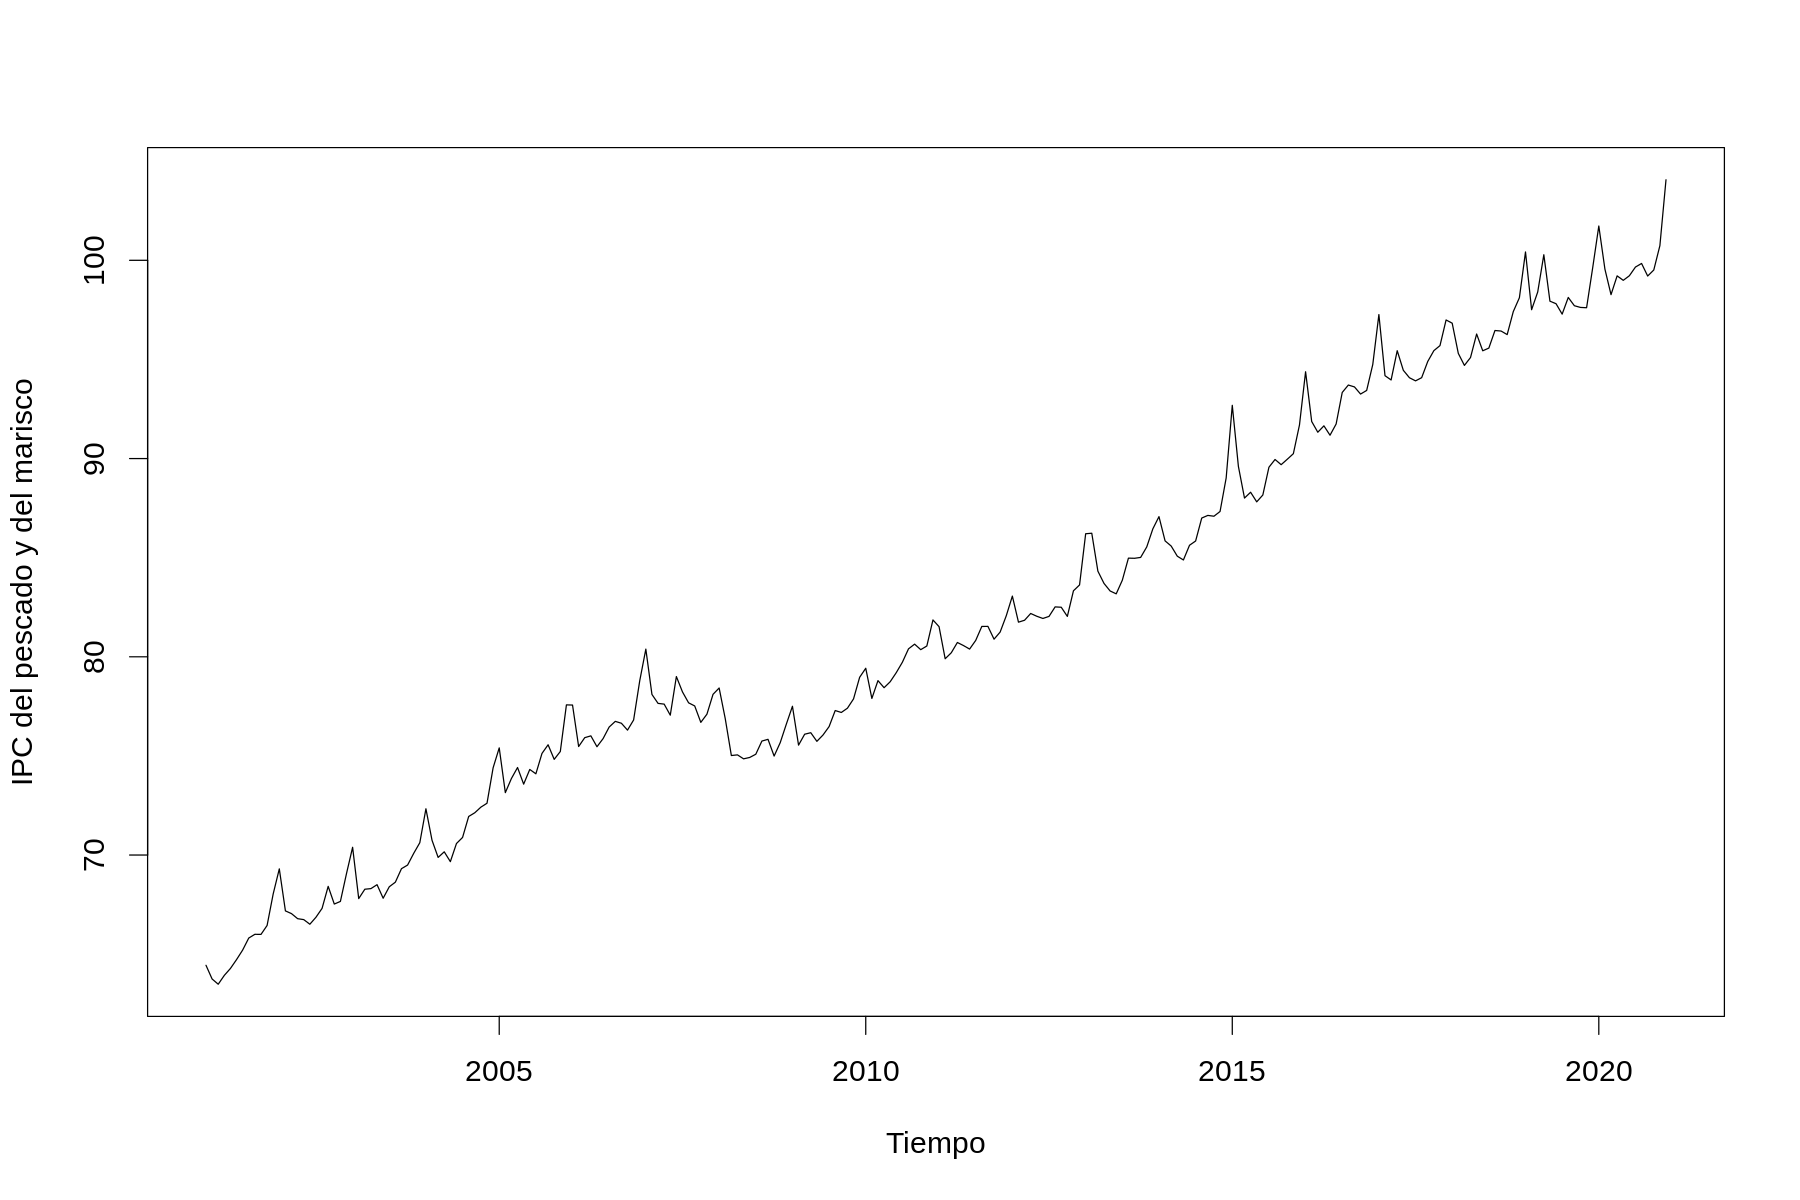

In [ ]:
#Cambiamos el tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)
#Graficamos la serie temporal:
plot(Serie_IPC, xlab="Tiempo", ylab="IPC del pescado y del marisco")

A primera vista podemos decir que la serie presenta tendencia ascedente y estacionalidad.

Asimismo, vemos una bajada brusca del índice en torno al año 2008 de la que la serie tarda unos años en recuperarse. Estamos ante un claro efecto de la crisis económica que comenzó en 2007-2008. 

###**Dependencia entre variabilidad y nivel**

Una cuestión muy importante a la hora de descomponer una serie temporal consiste en estudiar si existe dependencia entre la variabilidad de la serie y su nivel.

Si la variabilidad de una serie no depende del nivel, los componentes de la serie de combinan de manera aditiva:

\begin{align}
X_t = U + T_t + C_t + S_t + R_t
\end{align}

(*U* es la media de la serie.)

Si la serie sigue un modelo aditivo, el incremento debido a la estacionalidad siempre es el mismo, aunque exista tendencia creciente o decreciente.

Por el contrario, si la variabilidad y el nivel dependen entre sí, de forma que a mayor nivel mayor variabilidad, los componentes de la serie se combinan de forma multiplicativa:
\begin{align}
X_t = U * T_t * C_t * S_t * R_t
\end{align}

La diferencia entre los esquemas aditivo y multiplicativo la podemos ver más clara mediante los gráficos de la siguiente imagen:

![picture](https://raw.githubusercontent.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/master/Images/Series%20Temporales%20Esquemas%20aditivo%20y%20multiplicativo.png)

En el esquema aditivo, la variabilidad se mantiene entre dos franjas paralelas (no aumenta ni disminuye), aunque la serie tenga tendencia. Sin embargo, la serie multiplicativa presente una variabilidad creciente (forma de trompeta).

En nuestra serie del IPC del pescado y del marisco, a simple vista cuesta reconocer si la serie sigue un modelo aditivo o multiplicativo.

Por ello, vamos a emplear una herramienta muy útil para ver si existe dependencia entre nivel y variabilidad: gráfico de dispersión entre una medida de variabilidad (por ejemplo, el rango) y una de nivel (por ejemplo, la media).

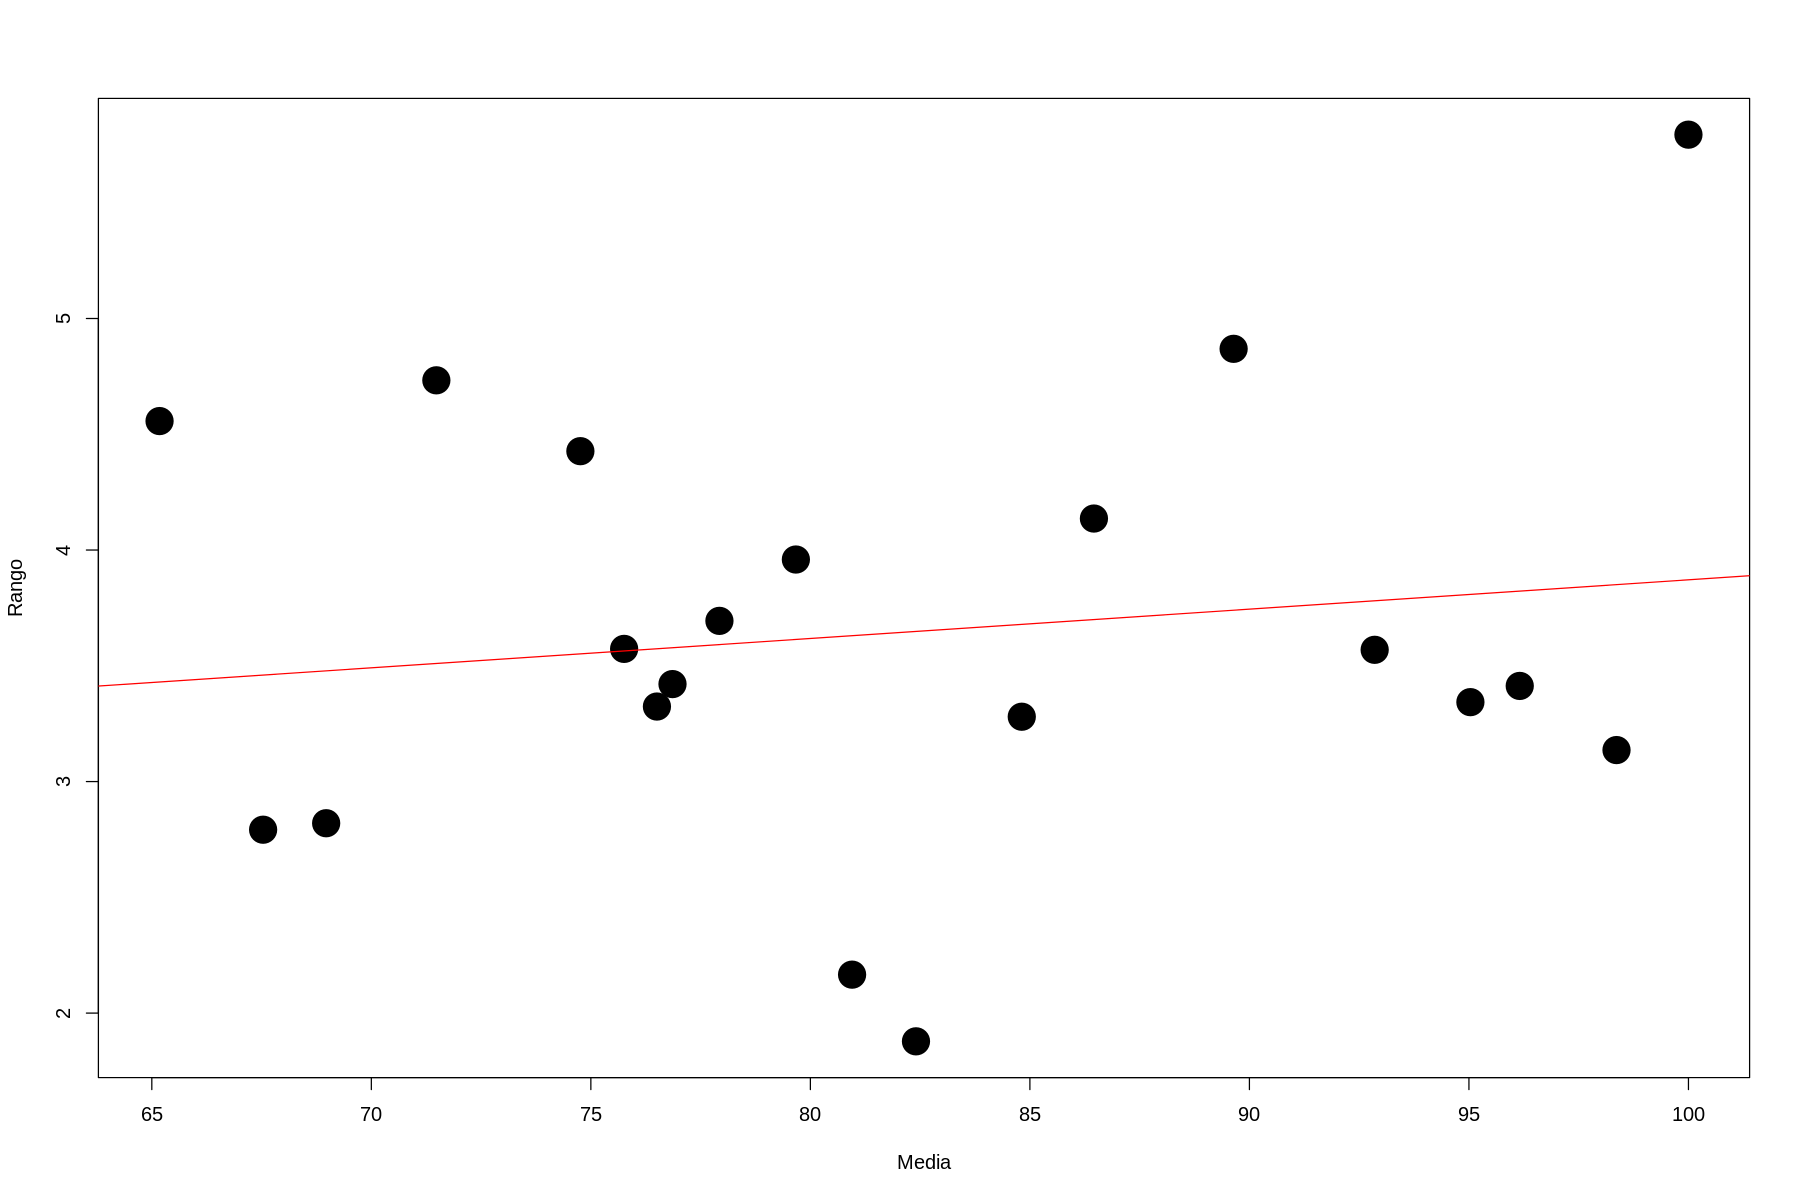

In [ ]:
#Creamos una matriz a partir del objeto time series Serie_IPC
matriz <- do.call(cbind, split(Serie_IPC, cycle(Serie_IPC)))

#Creamos una función que calcule el rango, ya que no existe dicha función en R:
rango <- function(x){
    rango = max(x) - min(x)
    return(rango)
}

#Calculamos el rango anual (variabilidad anual):
Rango <- apply(matriz, 1, rango)
#Calculamos la media anual:
Media <- apply(matriz, 1, mean)

#Realizamos el diagrama de dispersión (marcando la pendiente de la nube de puntos):
plot(Media, Rango,
     pch=19, #Modifica la forma de los puntos
     cex=3)  #Modifica el tamaño de los puntos
abline(lm(Rango ~ Media), col="red")

Aunque la pendiente de la nube de puntos es ligeramente positiva, no parece haber un patrón claro por el que, al aumentar el nivel (la media), aumente la variabilidad (el rango). Por ello, en principio, parece que el modelo que sigue la serie temporal es aditivo.

###**Comprobar la existencia de estacionalidad**

Ya hemos comentado anteriormente que el gráfico parece mostrar una estacionalidad clara: aumentando el IPC ciertos meses todos los años y disminuyendo otros.

Para corroborar esta idea, vamos a realizar un gráfico *box-plot*:

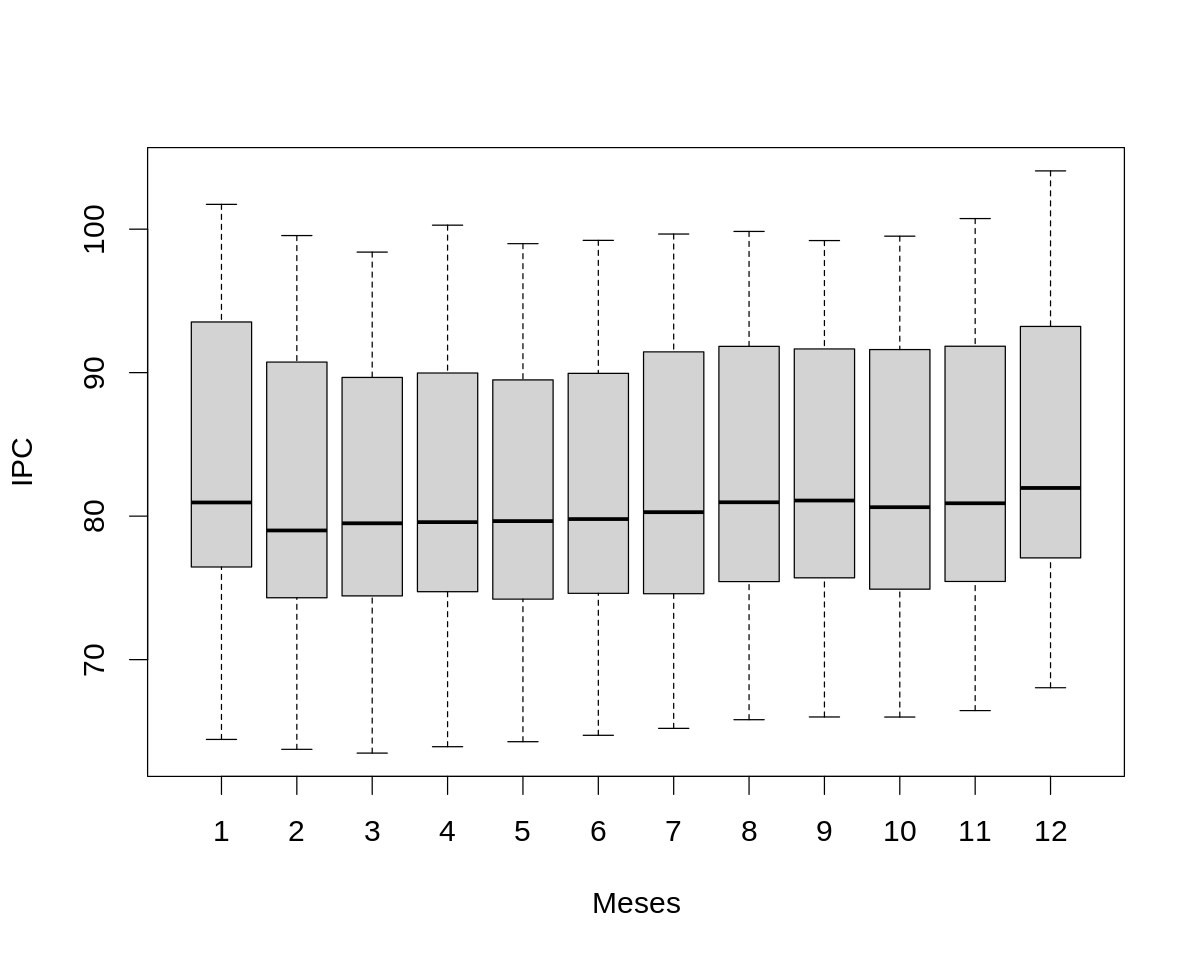

In [ ]:
#Configuramos el tamaño del gráfico y los títulos de los ejes:
options(repr.plot.width=10, repr.plot.height=8)
par(cex=1.5)
#Realizamos el box-plot:
boxplot(Serie_IPC ~ cycle(Serie_IPC), xlab="Meses", ylab="IPC")

La primera caja del *box-plot* representa todos los eneros, la segunda, los febreros y así sucesivamente. Como vemos, el precio medio no es el mismo para todos los meses, siendo mayor en los meses de diciembre y enero. Esto tiene sentido, ya que nuestra serie muestra el índice del IPC para el pescado y el marisco, productos con un consumo bastante regular a lo largo del año, pero con mayor demanda durante las festividades navideñas. Por tanto, parece claro que la serie presenta estacionalidad.

Entonces, al descomponer la serie deberemos aislar la ciclo-tendencia por una parte, y, por otra, la estacionalidad, con la finalidad de obtener finalmente el residuo, que será ruido blanco si la serie se encuentra bien ajustada al modelo.

###**Descomposición manual de la serie**

Descomponer manualmente una serie temporal consiste en ir eliminando uno a uno cada uno de sus componentes estructurales, como la ciclo-tendencia o la estacionalidad, hasta quedarnos solamente con el residuo. Por ello, debemos recordar el modelo que, en principio, parece seguir la serie:
\begin{align}
X_t = U + T_t + C_t + S_t + R_t
\end{align}

Sin embargo, a la hora de realizar la descomposición manual, se suele utilizar un modelo formado solo por tres componentes principales: ciclo-tendencia, estacionalidad y ruido:
\begin{align}
Y_t = CT_t + S_t + R_t
\end{align}

######**Paso 1: Aislar y eliminar la ciclo-tendencia**

El primer paso de la descomposición manual consiste en aislar y, una vez aislada, restar la ciclo-tendencia del resto de la serie, para así quedarnos solamente con una serie que contenga estacionalidad y residuo.

Para realizar esto, podemos hacer uso de medias móviles (*moving averages*). La técnica de medias móviles consiste en sustituir cada componente de la serie por una media local calculada a partir de los componentes adyacentes a cada observación de la serie.

Consideremos, por ejemplo, una serie con 100 observaciones a la que se aplica medias móviles de orden 25. Esto quiere decir que el primer valor de la serie de medias móviles será el promedio de los primeros 25 términos, luego el promedio de las observaciones 2 a 26; el tercer elemento, será la media de los términos 3 al 27 y así sucesivamente, siendo el último elemento de la serie de medias móviles el promedio de los últimos 25 números (del 76 al 100).

De esta forma vemos que:
1. Se va desplazando el cálculo de la media una posición cada vez - de ahí el nombre de medias *móviles*.
2. La nueva serie pierde elementos por el principio y por el final. En el ejemplo anterior, perderíamos las 12 primeras observaciones y las 12 últimas.

La cuestión es, por tanto: ¿Qué orden de medias móviles debemos utilizar? Esta pregunta no tiene respuesta concreta, sino que depende de la serie. Lo normal suele ser empezar con un orden bajito, de 3, e ir subiendo siguiendo la idea de suavizar la serie sin perder mucha información y conseguir un buen ajuste a la serie temporal. Una práctica habitual en este sentido suele ser elegir un orden igual al número de periodos estacionales (en nuestro caso, las observaciones son mensuales, por lo que cogeremos un orden $n = 12$).

Para usar medias móviles en R tenemos la función `ma()`, del paquete `forecast`.

In [ ]:
#Calculamos la serie de medias móviles:
serie_medias_moviles <- ma(Serie_IPC,
                           order = 12, 
                           centre=T) #Cuando el orden es par, suele utilizarse esta opción
serie_medias_moviles

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2001,NA,NA,NA,NA,NA,NA,65.37892,65.72475,66.01625,66.28371,66.50546,66.68242
2002,66.82567,66.95692,67.12000,67.28454,67.39892,67.49225,67.58038,67.65158,67.72875,67.84329,67.97992,68.10800
2003,68.22671,68.34588,68.43821,68.55737,68.74033,68.90617,69.05192,69.25542,69.44487,69.58908,69.71483,69.87821
2004,70.09692,70.33871,70.59425,70.83350,71.06063,71.32338,71.60875,71.83687,72.10292,72.44600,72.78608,73.10467
2005,73.39404,73.66025,73.93563,74.17892,74.38804,74.62904,74.85137,75.03833,75.22100,75.37329,75.51846,75.66188
2006,75.82500,75.99071,76.10333,76.21000,76.33767,76.45446,76.62254,76.84954,77.03104,77.16979,77.30283,77.49962
2007,77.70383,77.81654,77.89188,77.94458,77.97308,77.95687,77.84679,77.71421,77.55375,77.33750,77.13904,76.87721
2008,76.57621,76.36492,76.21442,76.07342,75.94283,75.82046,75.71946,75.62546,75.61463,75.70600,75.78937,75.87333
2009,75.97862,76.10088,76.22146,76.37850,76.57096,76.76125,76.93954,77.11754,77.32829,77.53550,77.75533,78.01179
2010,78.27833,78.54337,78.81667,79.08329,79.31754,79.54929,79.75725,79.92808,80.07004,80.22363,80.39471,80.52017


Comprobamos como, al utilizar una media móvil de orden 12, hemos perdido las 6 primeras y las 6 últimas observaciones.

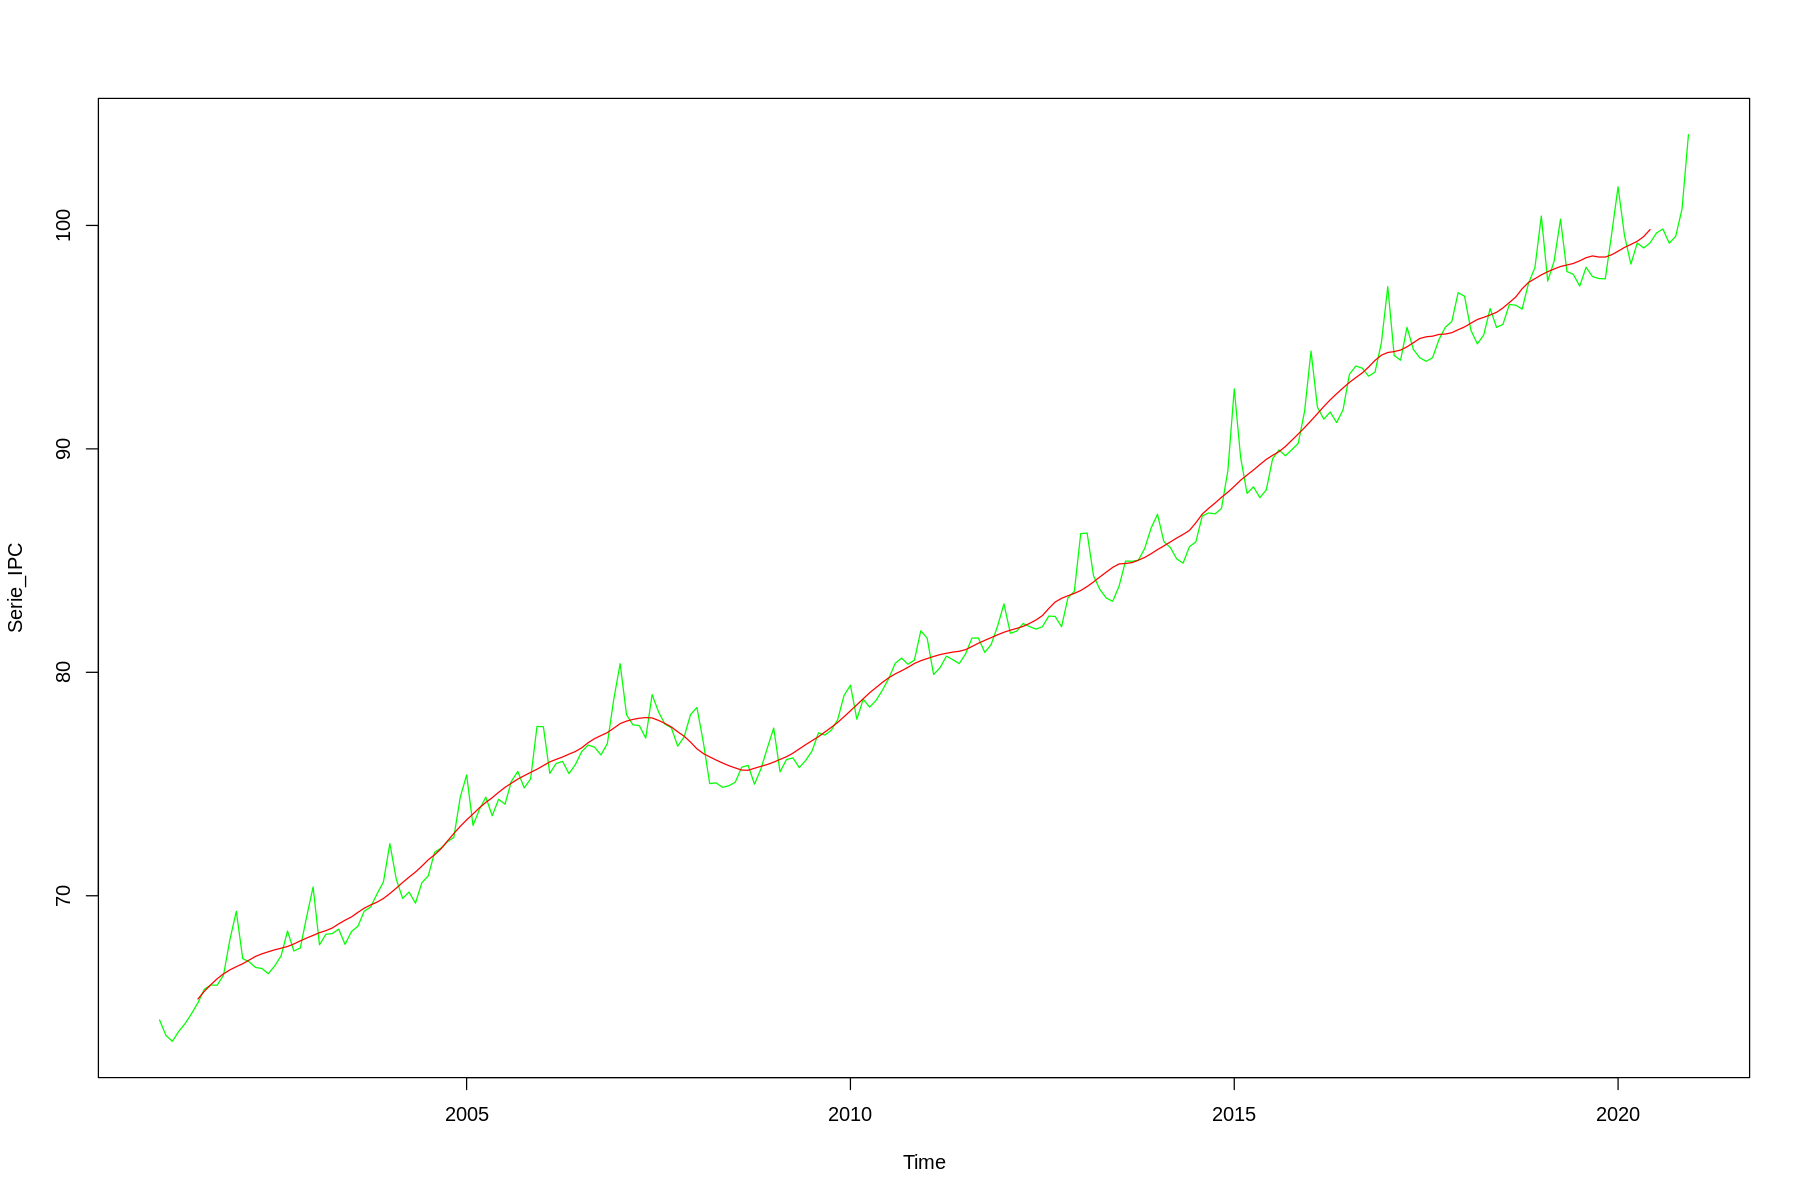

In [ ]:
#Representamos la serie original y la serie de medias móviles:
options(repr.plot.width=15, repr.plot.height=10)
plot(Serie_IPC, col="green")
lines(serie_medias_moviles, col="red")

Al utilizar medias móviles obtenemos una serie suavizada, que recoge los componentes ciclo y tendencia. La ciclo-tendencia, como ya habíamos visto anteriormente, es ascedente.

Asimismo, como estamos considerando un modelo aditivo, si a la serie original le restamos la serie de medias móviles, conseguiremos una serie con solo dos componentes: estacionalidad y residuo:
\begin{align}
Y_t - CT_t = S_t + R_t
\end{align}

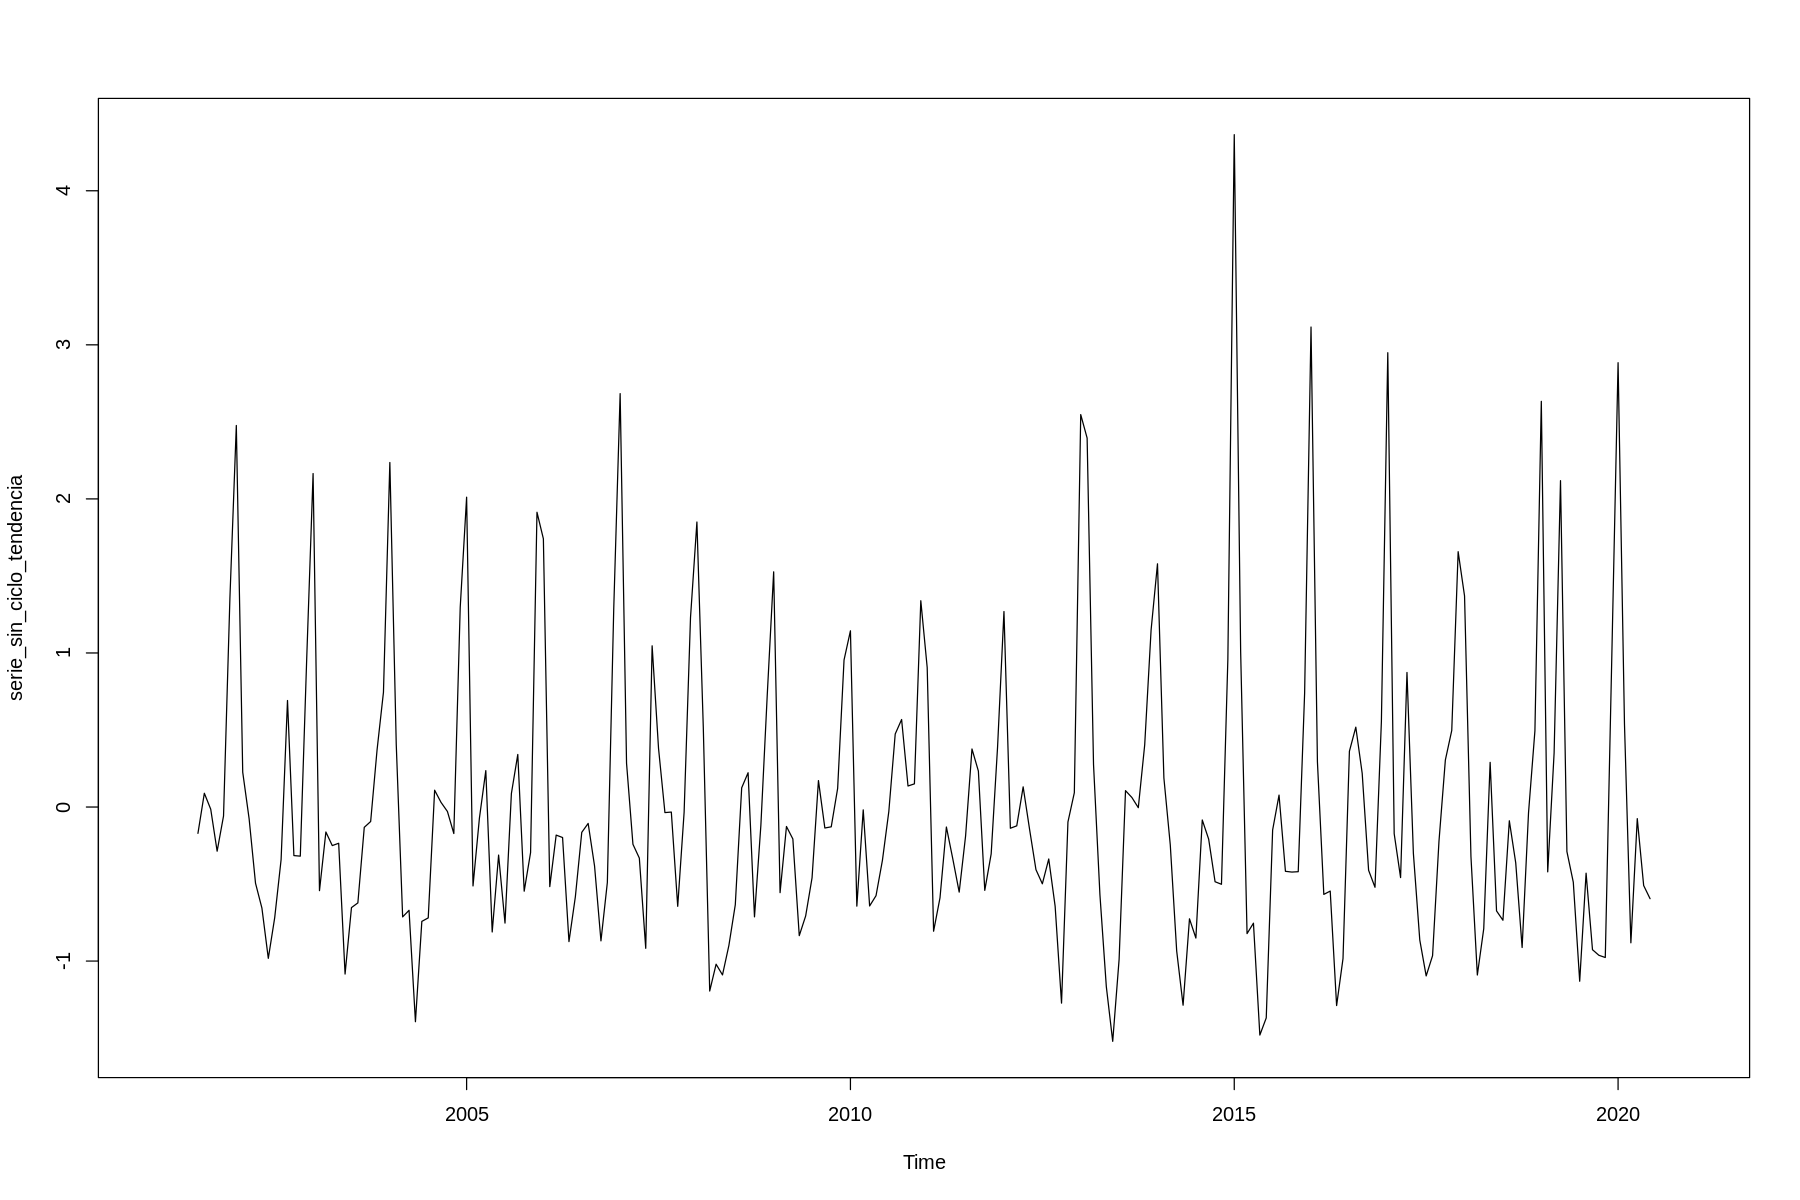

In [ ]:
serie_sin_ciclo_tendencia <- Serie_IPC - serie_medias_moviles
plot(serie_sin_ciclo_tendencia)

En este gráfico tenemos la serie temporal sin ciclo-tendencia. En él, observamos que la variabilidad estacional no aumenta ni disminuye claramente conforme va pasando el tiempo, por lo que tenemos otra prueba de que el esquema que sigue nuestra serie no es multiplicativo. Sin embargo, tampoco apreciamos una variabilidad estable. Esto puede darnos problemas de ajuste al final.

######**Paso 2: eliminar la componente estacional**

Una vez eliminada la ciclo-tendencia, debemos eliminar la estacionalidad. Considerando, de nuevo, un modelo aditivo, la operación a realizar será la siguiente:
\begin{align}
Y_t - CT_t - S_t = R_t
\end{align}

Para aislar la estacionalidad, debemos calcular la media por cada periodo estacional. En nuestro caso, debemos calcular la media mensual:

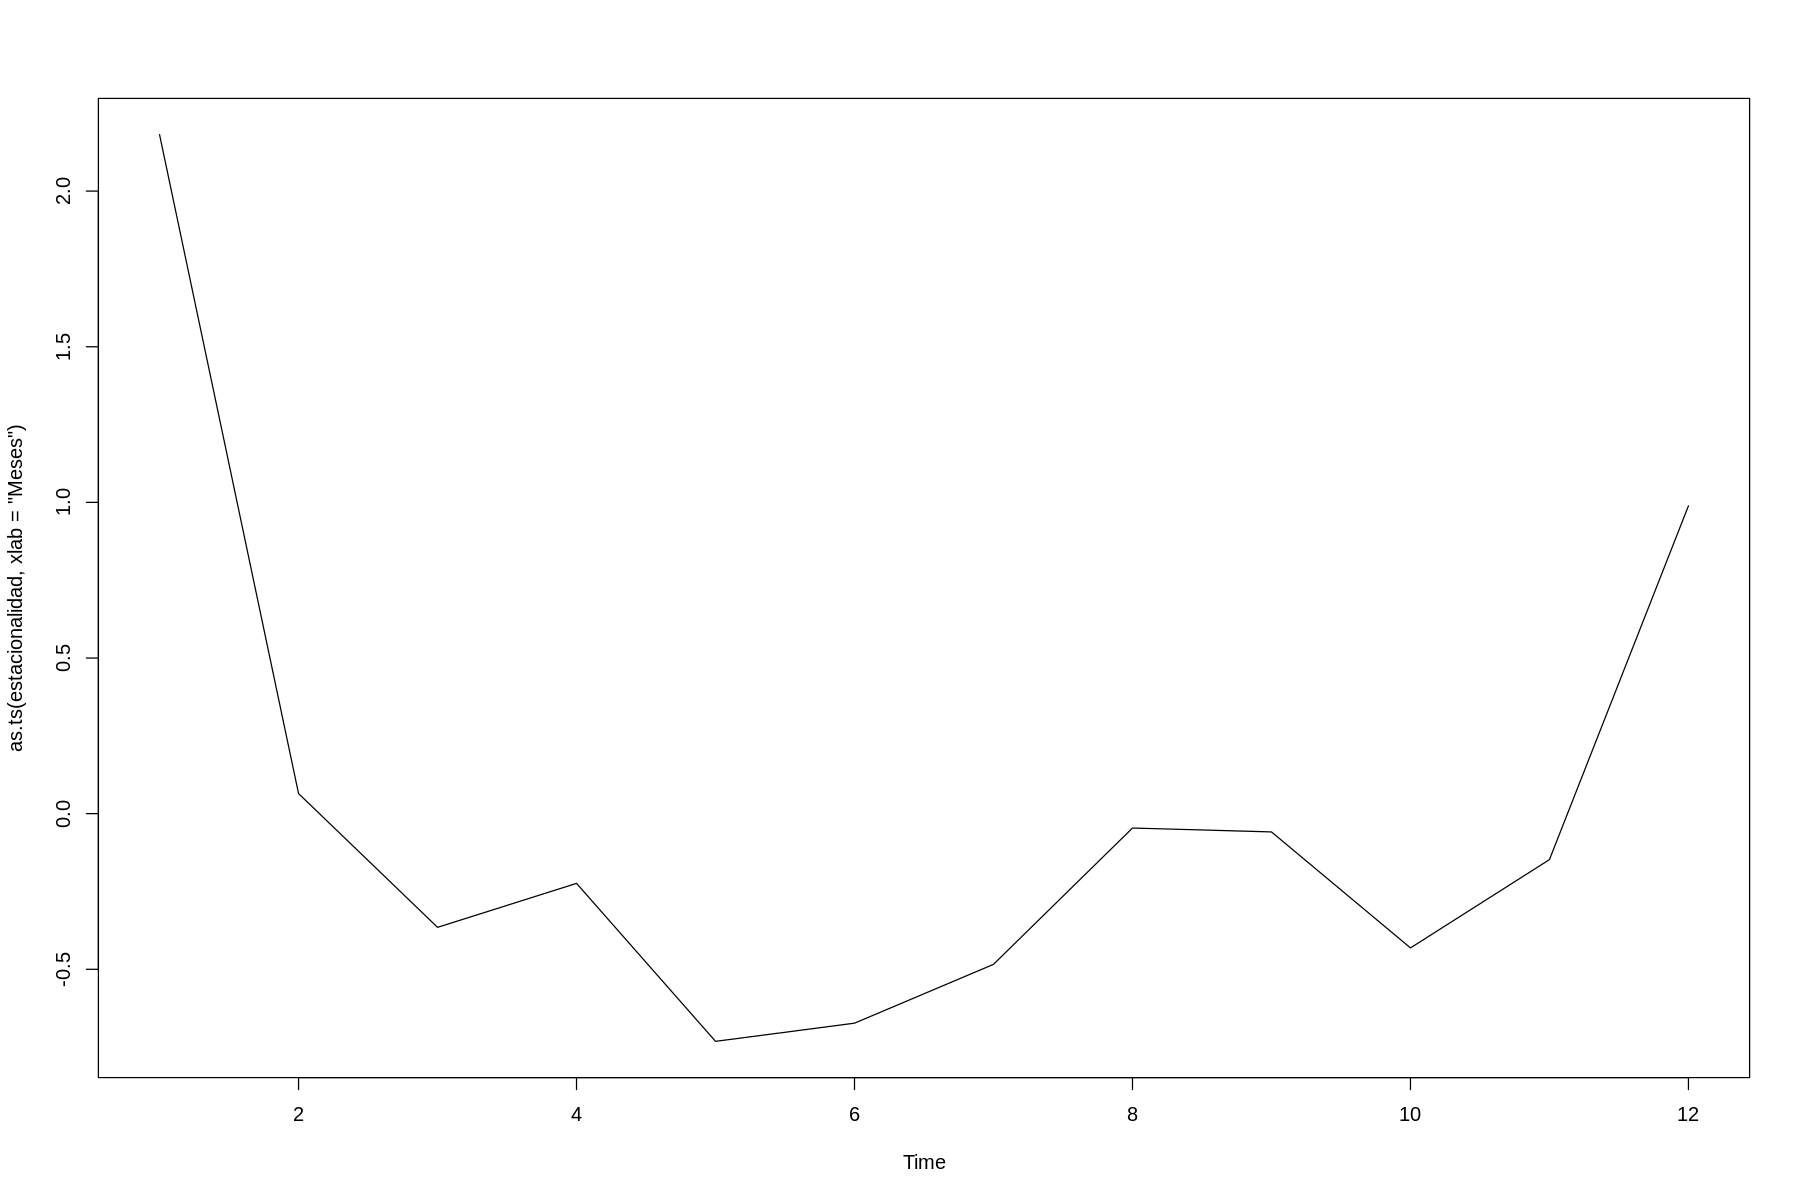

In [ ]:
#Creamos una matriz a partir del objeto time series serie_sin_ciclo_tendencia
matriz <- do.call(cbind, split(serie_sin_ciclo_tendencia, cycle(serie_sin_ciclo_tendencia)))

#Calculamos la media de cada columna de la matriz: la media mensual
estacionalidad <- apply(matriz, 2, mean, na.rm=TRUE) #La opción na.rm = TRUE es necesario usarla, pues tenemos datos perdidos

#Graficamos la estacionalidad:
plot(as.ts(estacionalidad, xlab="Meses"))

Este gráfico refleja la estacionalidad de un año tipo. Como ya hemos indicado, el mayor valor del índice se alcanza en enero y diciembre, pues son los meses en los que más pescado se demanda debido a la Navidad. Asimismo, observamos mínimos locales en abril y agosto. Podríamos decir también que el consumo de pescado y marisco aumenta por Semana Santa y verano, lo que también tiene sentido - sobre todo, el aumento estival.

A continuación, para quedarnos solamente con el residuo, restamos la estacionalidad (a cada mes, le quitamos el dato de estacionalidad que le corresponda):

In [ ]:
residuo <- serie_sin_ciclo_tendencia - estacionalidad

######**Paso 3: análisis de los residuos**

Nuestra serie estará bien ajustada al modelo propuesto - aditivo, en nuestro caso - si los residuos son ruido blanco.

Los residuos son ruido blanco ($\varepsilon_t$) si su media es cero, su varianza es constante (son homocedásticos) y son independientes (su covarianza y, por tanto, su correlación es cero):
\begin{align}
\varepsilon_t \sim N(0, \sigma^2) \ \ \ \ \ cov(\varepsilon_{t_i}, \varepsilon_{t_j}) = 0 \ \ \forall \  t_i \neq t_j
\end{align}

Podemos comprobar fácilmente si el primer requisito (media cero) se cumple:

In [ ]:
mean(residuo, na.rm = TRUE)

[1] 8.167181e-18

Parece que se cumple, pues el valor es cercano a cero.

Graficamos el residuo para comprobar si la varianza es constante:

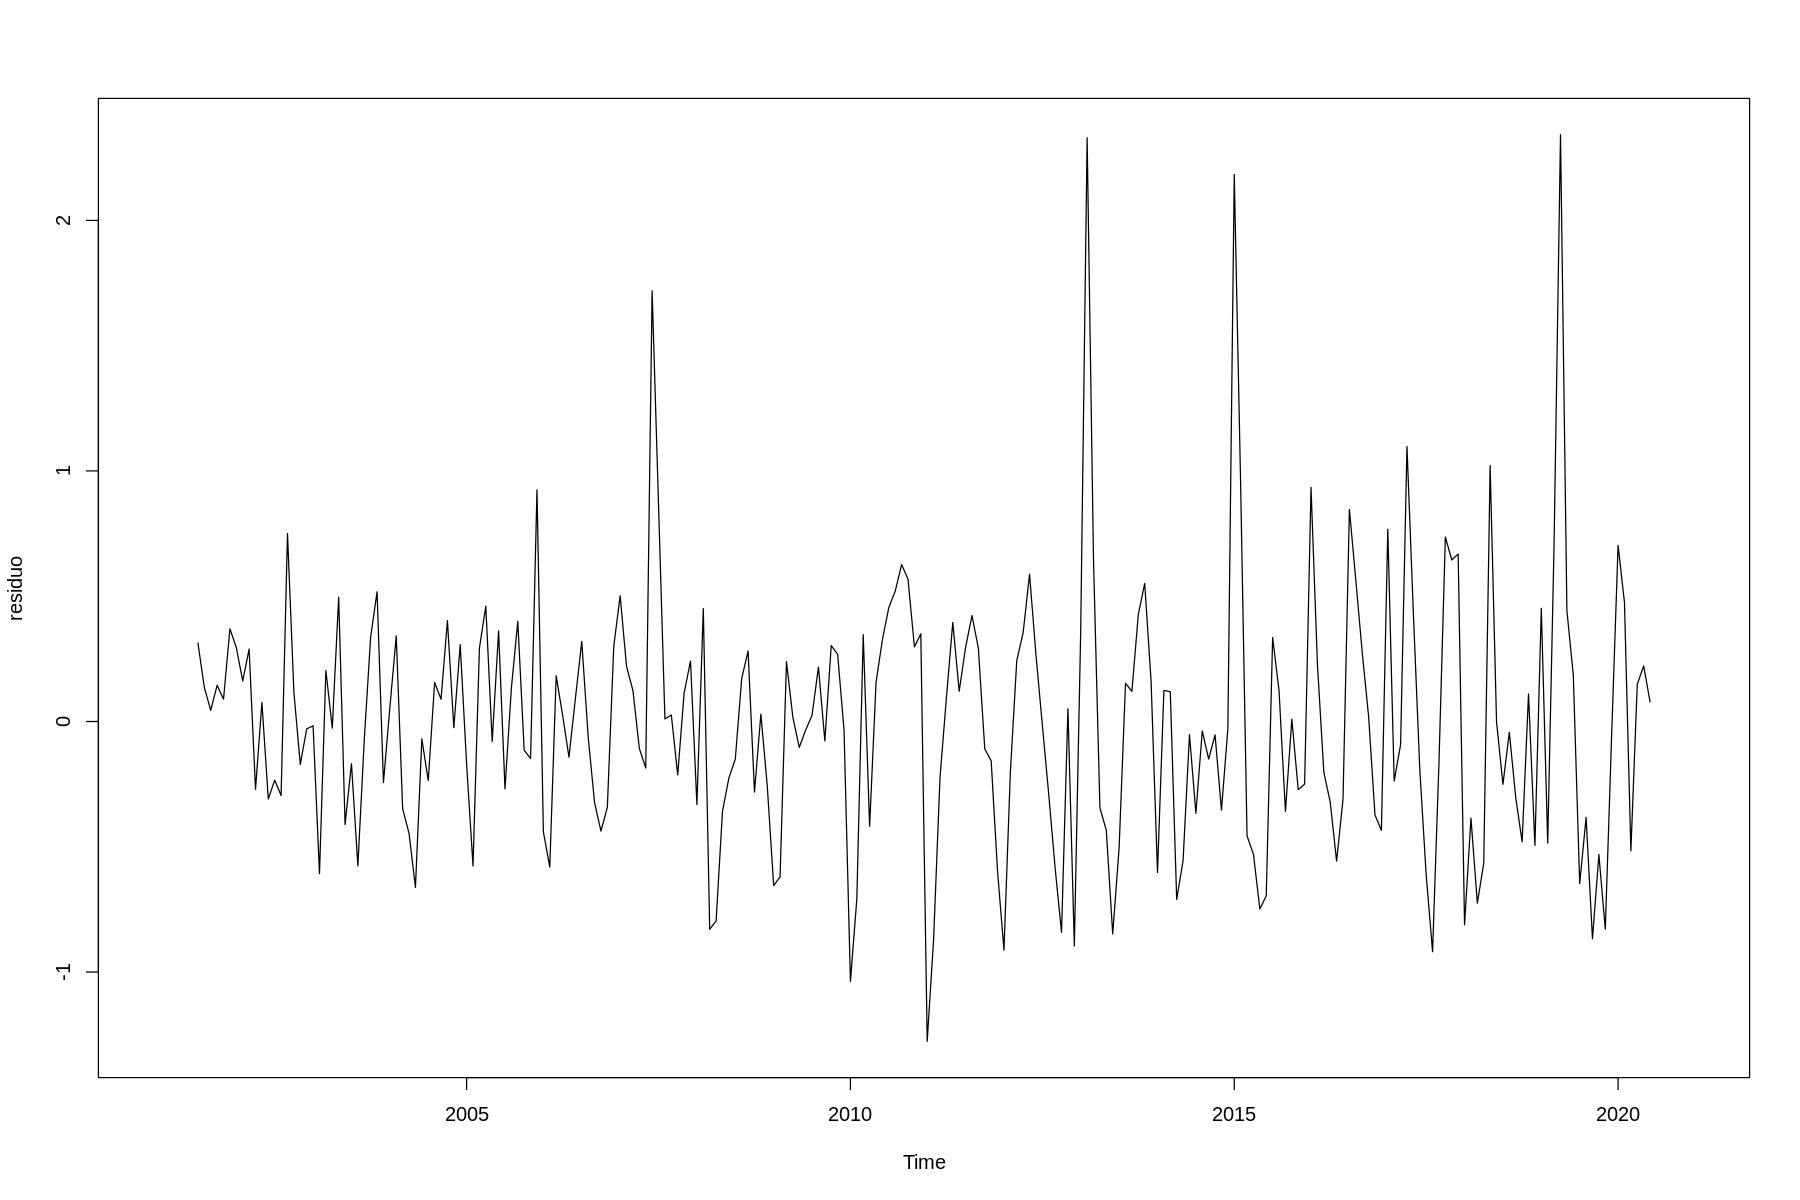

In [ ]:
plot(residuo)

Como vemos, la varianza no es constante, ya que hay tramos, momentos, donde ésta es mayor y otros, donde es es menor. Por ello, nuestro residuo no es ruido blanco y, por ello también, nuestro modelo aditivo no se adecúa perfectamente a los datos.

######**Posible paso adicional: probar otro modelo**

Debido a que los residuos no son ruido blanco, no podemos considerar que nuestra serie siga un modelo aditivo. Por tanto, pese a que varios indicios nos han llevado a pensar que los componentes de la serie siguen un modelo aditivo, vamos a descomponer la serie siguiendo un modelo multiplicativo, para ver si así solucionamos el problema de heterocedasticidad residual. Vamos a emplear el método `decompose()`, que realiza la descomposición automáticamente, centrándonos en los gráficos:

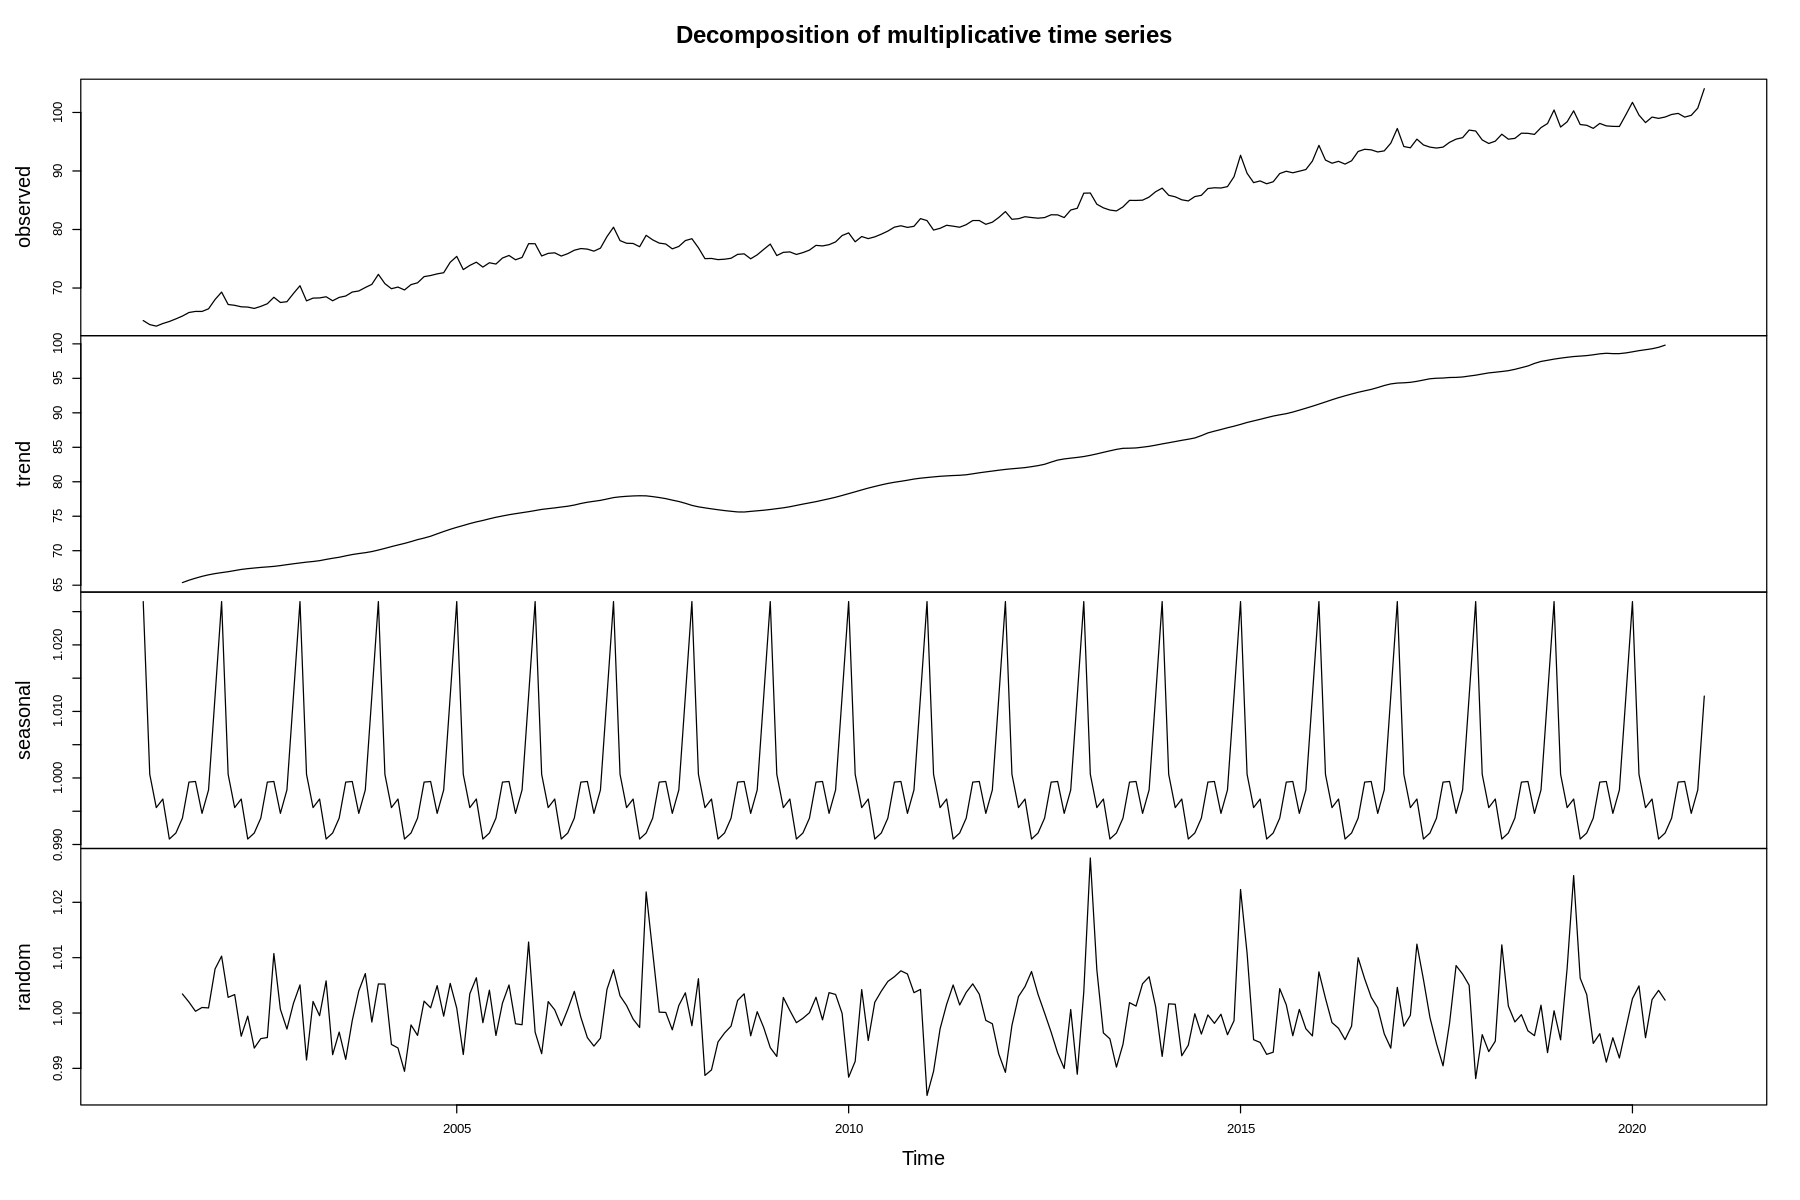

In [ ]:
plot(decompose(Serie_IPC, type="multiplicative"))

La función `decompose()` realiza de manera automática todo el proceso que hemos desarrollado paso a paso en este modelo. Acepta los tipos `additive` (aditivo) y `multiplicative` (multiplicativo).

Al observar el gráfico de los residuos (`random`) a simple vista comprobamos que la variabilidad tampoco es constante, por lo que el modelo que siguen los datos no es multiplicativo.

En este caso, puede que los datos sigan un modelo mixto, como el siguiente:
\begin{align}
X_t = U * T_t * C_t * S_t + R_t
\end{align}
Que combina multiplicaciones y sumas.

######**Posible paso adicional: realizar transformaciones sobre la serie original**

Si el modelo propuesto no ajusta los datos, muy posiblemente deberemos realizar algún tipo de transformación sobre la serie original antes de realizar cualquier descomposición. 

Entre las transformaciones más comunes tenemos el uso de diferencias de orden 1 o de logaritmos.

En este cuaderno, solo dejamos apuntado que se pueden realizar dichas transformaciones. Sin embargo, su desarrollo lo dejaremos para otro cuaderno más avanzado que hable sobre series estacionarias y procesos $ARMA(p, q)$.

###**Conclusiones**

La serie temporal del IPC del pescado y marisco entre los años 2002 y 2021 presenta una clara estacionalidad y una tendencia ascedente. Asimismo, respecto a la primera, los meses de Navidad (diciembre y enero) son los que presentan un mayor nivel del índice. Por último, el modelo que sigue la serie no es aditivo ni multiplicativo, aunque los indicios existentes parecen mostrar que se acerca más al primer tipo.